# **Clustering Assignment 2: Sessa Empirical Estimator (SEE)**
## 📝 **Instructions**
1) ✅**Read the Journals** about the Sessa Empirical Estimator.
2) ✅**Convert the R codes into Python** Codes (use jupyter notebook).
3) ⏺**Perform the Sessa Empircal Estimator and generate some insights** using either: 
    - Simulated data (https://www.frontiersin.org/journals/pharmacology/articles/10.3389/fphar.2019.00383/full) or 
    - Real world datasets of your choice (You can obtain it in Kaggle or in https://archive.ics.uci.edu/),
4) ⏺**Generate a new insight using the new clustering algorithm**
    - SEE uses K-Means clustering (again recall the disadvantages of K-Means)
    - Substitute a different clustering algorithm (DBSCAN)
5) ⏺**Compare your results between**:
    - SEE using K-Means, and 
    - SEE using the clustering algorithm of your choice.
6) Deadline is this **Sunday, Feb 23,** ~~2022~~ **2025 at 11:59 pm**
7) ✅ Do this with your thesis partner.
8) ✅ You can use any A.I. assistant.
---

## 👩‍💻 **Converting R Code to Python Code**


### 🦺 Memory Leak Prevention
 - KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads
 - Settings the OMP_NUM_THREADS env to 2 or 1 fixes this

In [98]:
import os
os.environ["OMP_NUM_THREADS"] = "1"

### 💥**Importing necessary libraries** 💥
#### Data Handling
1. `pandas`: Used for handling tabular data (like data frames in R). Equivalent to `dplyr` in R
2. `numpy`: Provides numerical operations, including array manipulations and mathematical functions.

In [99]:
import pandas as pd
import numpy as np

#### Data Visualization
1.  `matplotlib.pyplot`: Equivalent to R's `plot()`, used for static graphs.
2. `seaborn`: Used for statistical visualizations, like box plots (similar to R's `ggplot2`).


In [100]:
import matplotlib.pyplot as plt
import seaborn as sns

#### Statistical Distribution
1. `ecdf`: It is used to analyze the distribution of the event.interval values in your dataset

In [101]:
from scipy.stats import ecdf

### Machine Learning (Clustering)
1. `KMeans`: Implements K-Means clustering (equivalent to R’s kmeans()).
2. `DBSCAN`: Alternative for K-Means clustering for SEE
3. `silhouette_score`: Calculates the silhouette
4. `StandardScaler`: Standardizes data (similar to R's scale()).

In [104]:
from sklearn.cluster import KMeans, DBSCAN
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler

#### **Summary Table of R-to-Python Imports**
| Functionality | R Equivalent | Python Equivalent |
| --- | --- | --- |
| Data Manipulation | `dplyr`, `data.table` | `pandas` |
| Numerical Computations | `base::log`, `scale()` | `numpy`, `scipy` |
| Plotting | `ggplot2`, `plot()`	| `seaborn`, `matplotlib.pyplot` |
| Event Interval | `event.interval` | `ecdf` |
| Clustering (K-Means) | `kmeans()` | `sklearn.cluster.KMeans` |
| Clustering (DBSCAN) | *-* | `sklearn.cluster.DBSCAN` | 
| Silhouette Score | *-* | `sklearn.metrics.silhouette_score` |
| Data Scaling | `scale()` | `sklearn.preprocessing.StandardScaler` |


### 💥**Main Functions**💥
1. `see(arg1, tidy)` – Implements the **Sessa Empirical Estimator (SEE)** using K-Means and DBSCAN (alt) clustering.

In [121]:
def see(arg1, tidy: pd.DataFrame, algorithm="kmeans"):
    C09CA01 = tidy[tidy["ATC"] == arg1].copy()
    
    # Take a random sequence of consecutive prescription in the dataset
    Drug_see_p0: pd.DataFrame = C09CA01.copy()
    Drug_see_p1: pd.DataFrame = C09CA01.copy()
    
    Drug_see_p1 = Drug_see_p1.sort_values(by=["pnr", "eksd"])
    Drug_see_p1["prev_eksd"] = Drug_see_p1.groupby("pnr")["eksd"].shift(1)
    Drug_see_p1 = Drug_see_p1.dropna(subset=["prev_eksd"])
    
    # Sample one row per patient
    Drug_see_p1 = Drug_see_p1.groupby("pnr").apply(lambda x: x.sample(1)).reset_index(drop=True)
    Drug_see_p1 = Drug_see_p1[["pnr", "eksd", "prev_eksd"]]
    
    # Calculate event interval
    Drug_see_p1["event.interval"] = (Drug_see_p1["eksd"] - Drug_see_p1["prev_eksd"]).dt.days
    Drug_see_p1["event.interval"] = Drug_see_p1["event.interval"].astype(float)
    
    # ECDF plot
    ecdf_values = ecdf(Drug_see_p1["event.interval"])
    x = np.sort(Drug_see_p1["event.interval"])
    y = ecdf_values.cdf.evaluate(x)
    
    dfper = pd.DataFrame({"x": x, "y": y})
    
    # Retain the 20% of the ECDF
    dfper = dfper[dfper["y"] <= 0.8]
    
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(dfper["x"], dfper["y"], label="80% ECDF")
    plt.title("80% ECDF")
    
    plt.subplot(1, 2, 2)
    plt.plot(x, y, label="100% ECDF")
    plt.title("100% ECDF")
    plt.show()
    
    # Density plot of log(event interval)
    d = np.log(Drug_see_p1["event.interval"])
    sns.kdeplot(d, label="Log(event interval)")
    plt.title("Log(event interval)")
    plt.show()
    
    # Scale the data for clustering
    a = dfper[["x"]].values
    a = StandardScaler().fit_transform(a)  # Standardize the data
    
    if algorithm == "kmeans":
        # Silhouette Score for K-means
        silhouette_scores = []
        for n_clusters in range(2, 11):
            kmeans = KMeans(n_clusters=n_clusters, random_state=1234)
            cluster_labels = kmeans.fit_predict(a)
            silhouette_avg = silhouette_score(a, cluster_labels)
            silhouette_scores.append(silhouette_avg)
        
        max_cluster = np.argmax(silhouette_scores) + 2  # +2 because range starts at 2
        
        # K-means Clustering
        kmeans = KMeans(n_clusters=max_cluster, random_state=1234)
        dfper["cluster"] = kmeans.fit_predict(a)
    
    elif algorithm == "dbscan":
        # DBSCAN Clustering
        dbscan = DBSCAN(eps=0.5, min_samples=5)  # You can adjust eps and min_samples
        dfper["cluster"] = dbscan.fit_predict(a)
    
    else:
        raise ValueError("Invalid algorithm. Choose 'kmeans' or 'dbscan'.")
    
    # Summary statistics for clusters
    cluster_summary = dfper.groupby("cluster")["x"].agg(["min", "max", "median"])
    cluster_summary = cluster_summary.reset_index()
    cluster_summary.columns = ["Cluster", "Minimum", "Maximum", "Median"]
    
    # Merge results with original data
    results = pd.merge(Drug_see_p1, cluster_summary, how="cross")
    results["Final_cluster"] = np.where(
        (results["event.interval"] >= results["Minimum"]) & (results["event.interval"] <= results["Maximum"]),
        results["Cluster"], np.nan
    )
    results = results.dropna(subset=["Final_cluster"])
    
    # Get the most frequent cluster
    t1 = results["Cluster"].value_counts().idxmax()
    t1_merged = results[results["Cluster"] == t1].iloc[0]
    
    # Merge back to Drug_see_p1
    #Drug_see_p1 = Drug_see_p1.groupby("pnr").apply(lambda x: x.sample(1)).reset_index(drop=True)
    Drug_see_p1 = pd.merge(Drug_see_p1, results[["pnr", "Median", "Cluster"]], on="pnr", how="left")
    Drug_see_p1["Median"] = Drug_see_p1["Median"].fillna(t1_merged["Median"])
    Drug_see_p1["Cluster"] = Drug_see_p1["Cluster"].fillna(0)
    Drug_see_p1["test"] = Drug_see_p1["event.interval"] - Drug_see_p1["Median"]
    
    # Assign Duration
    Drug_see_p0 = pd.merge(Drug_see_p0, Drug_see_p1[["pnr", "Median", "Cluster"]], on="pnr", how="left")
    Drug_see_p0["Median"] = Drug_see_p0["Median"].fillna(t1_merged["Median"])
    Drug_see_p0["Cluster"] = Drug_see_p0["Cluster"].fillna(0)
    
    return Drug_see_p0

2. `see_assumption(tidy)` – Analyzes the assumptions behind the SEE, using **box plots and distribution analysis**.

In [110]:
def see_assumption(arg1):
    arg1 = arg1.sort_values(by=["pnr", "eksd"])
    arg1["prev_eksd"] = arg1.groupby("pnr")["eksd"].shift(1)
    
    Drug_see2 = arg1.copy()
    Drug_see2["p_number"] = Drug_see2.groupby("pnr").cumcount() + 1
    Drug_see2 = Drug_see2[Drug_see2["p_number"] >= 2]
    Drug_see2 = Drug_see2[["pnr", "eksd", "prev_eksd", "p_number"]]
    Drug_see2["Duration"] = (Drug_see2["eksd"] - Drug_see2["prev_eksd"]).dt.days
    
    # Boxplot with medians
    plt.figure(figsize=(10, 6))
    sns.boxplot(x="p_number", y="Duration", data=Drug_see2)
    
    medians_of_medians = Drug_see2.groupby("pnr")["Duration"].median().reset_index()
    plt.axhline(y=medians_of_medians["Duration"].median(), color="red", linestyle="--")
    plt.title("Duration by Prescription Number")
    plt.show()

### **Final Summary of Function Roles**
| **Function**       | **Purpose** |
|--------------------|------------|
| `see(arg1, tidy)` | Implements **Sessa Empirical Estimator (SEE)** using **K-Means and DBSCAN clustering** on prescription intervals. |
| `see_assumption(tidy)` | Analyzes **intervals between prescriptions** using **box plots and distribution analysis**. |


---
## 👨‍🏭 **Perform SEE on Simulated Data**

### **Extracting data from Library**

### **Import and clean extracted simulated data**

In [79]:
tidy = pd.read_csv('med_events.csv')
# add columns
tidy.columns = ["pnr", "eksd", "perday", "ATC", "dur_original"]
tidy['eksd'] = pd.to_datetime(tidy['eksd'], errors='coerce')

### **Perform SEE on data**

C:\Users\Matt\AppData\Local\Temp\ipykernel_22740\689570552.py:13: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  Drug_see_p1 = Drug_see_p1.groupby("pnr").apply(lambda x: x.sample(1)).reset_index(drop=True)


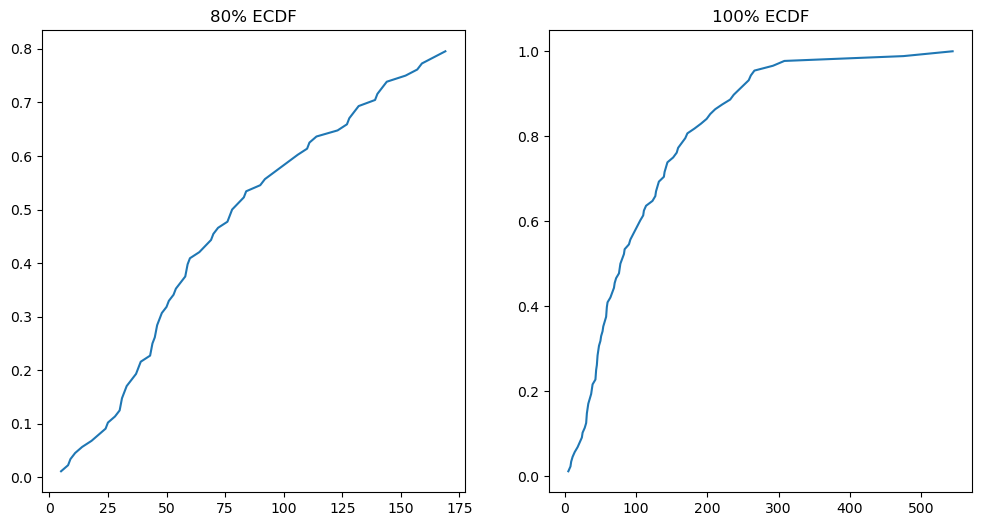

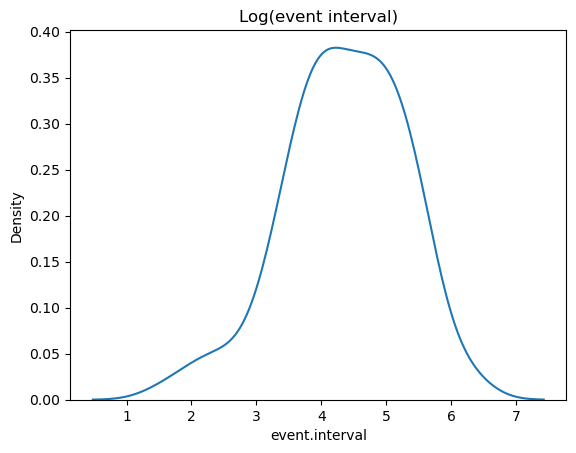

d:\Programs\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
d:\Programs\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
d:\Programs\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
d:\Programs\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, 

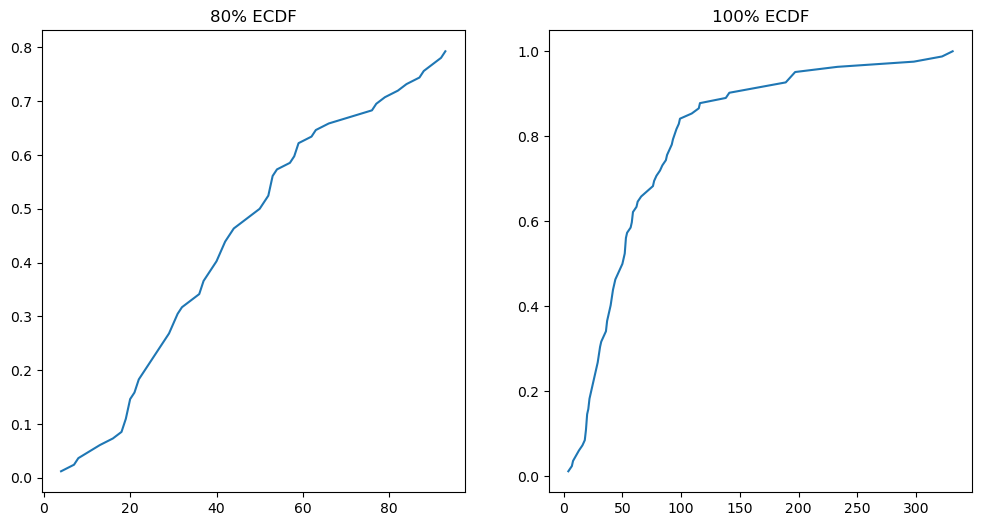

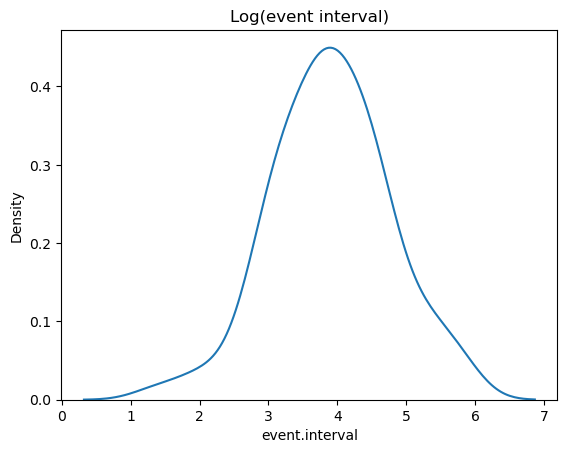

d:\Programs\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
d:\Programs\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
d:\Programs\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
d:\Programs\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, 

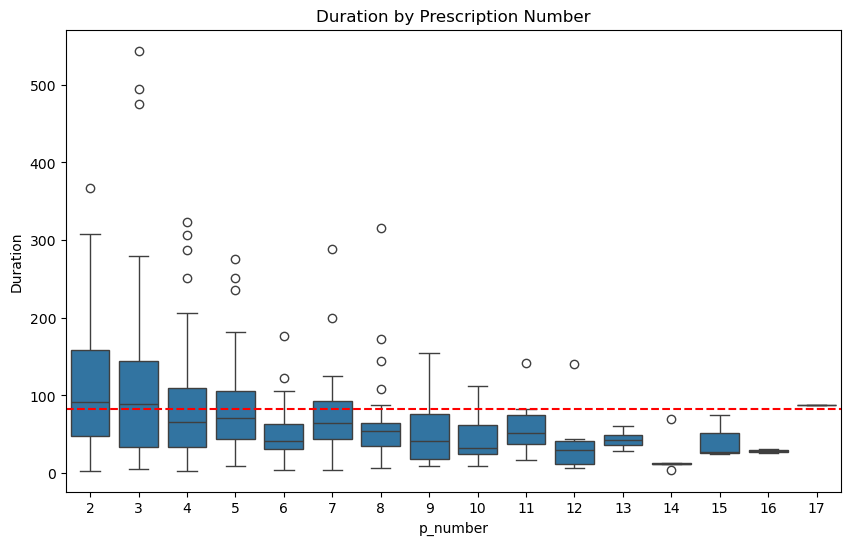

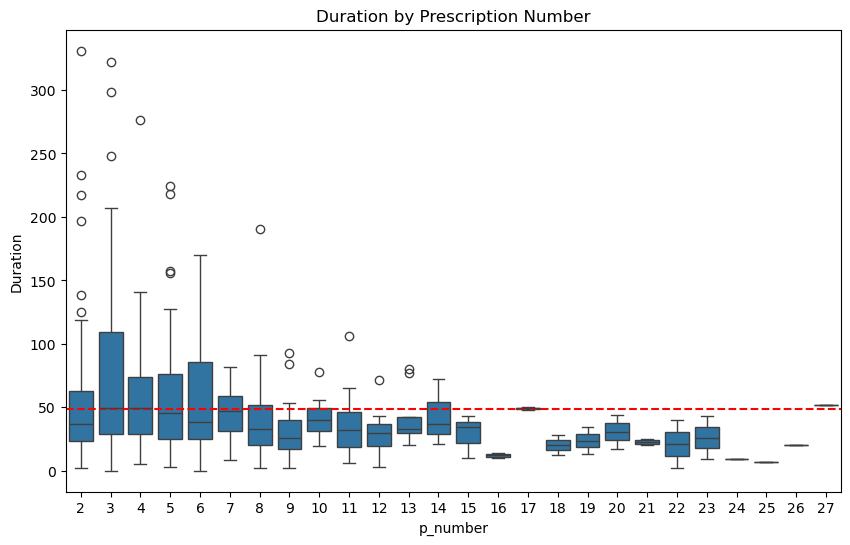

In [122]:
result_A = see('medA', tidy, "kmeans")
result_B = see('medB', tidy, "kmeans")

see_assumption(result_A)
see_assumption(result_B)